# DTSA 5510 Final Project

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import permutations

# old imports
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# latest imports
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from langdetect import detect

from textblob import TextBlob

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Data import

In [2]:
# data import
reviews = pd.read_csv('data/reviews.csv')

# Basic data cleaning

In [3]:
# here is an initial view of a sample of rows in the dataset
reviews.sample(5)

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,NAME
2840,2919307,2021-12-10,True,2,Issues,I've always bought Zagg privacy screen protect...,United States
2258,4860594,2018-04-29,True,5,Actually works!,"Lost my hair from chemo, so tried this to grow...",United States
1094,1290859,2022-05-24,True,5,It saves my life,"It arrived promptly. When I set it up, which w...",United States
6949,21848,2018-07-02,True,5,Great product. Great detoxyfier!,Took this one several times in the last 13 yea...,United States
2184,245090,2019-06-04,True,5,A life saver!!,I used to take this as a kid when I had bad al...,United States


In [4]:
# From the sample dataframe above, the 'NAME' field is misleading, it will be changed from 'NAME' to 'COUNTRY'
reviews.rename(columns={'NAME': 'COUNTRY'}, inplace = True)

In [5]:
# there are 10,000 reviews in our initial dataset.
# The 'REVIEW_TITLE' column has one null entry which we will remove in a subsequent cell
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            10000 non-null  int64 
 1   REVIEW_DATE   10000 non-null  object
 2   IS_VERIFIED   10000 non-null  bool  
 3   RATING        10000 non-null  int64 
 4   REVIEW_TITLE  9999 non-null   object
 5   REVIEW_TEXT   10000 non-null  object
 6   COUNTRY       10000 non-null  object
dtypes: bool(1), int64(2), object(4)
memory usage: 478.6+ KB


In [6]:
# Identifying the only row with a null value. Since we really care about the 'REVIEW_TEXT'
# this row could probably be left in but I will remove it just to be safe
reviews[reviews['REVIEW_TITLE'].isnull()]
reviews.dropna(subset = ['REVIEW_TITLE'], axis = 0, inplace = True)

In [7]:
# double checking that there are no more null values in the updated dataset
reviews.isnull().sum()

ID              0
REVIEW_DATE     0
IS_VERIFIED     0
RATING          0
REVIEW_TITLE    0
REVIEW_TEXT     0
COUNTRY         0
dtype: int64

In [8]:
reviews.head()

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,COUNTRY
0,3129911,2022-08-17,True,1,This has NO flavor,"This item has no flavor, several people have t...",United States
1,2702184,2022-06-07,True,1,Different formula,I have used this brand of sunscreen for about ...,United States
2,760128,2014-06-03,True,5,Vitex!!!,Have been using these for at least 20 months a...,United States
3,760140,2013-11-24,True,5,Stopping hair loss,Bought this to help fight hair loss along with...,United States
4,760132,2014-04-10,True,5,coming off of birth control,this company is one of the best most honest i'...,United States


In [9]:
# There are two more adjustments that need to be made. The 'REVIEW_DATE' column should be a datetime
# also the 'ID' field should be an object
reviews['REVIEW_DATE'] = pd.to_datetime(reviews['REVIEW_DATE'])
reviews['ID'] = reviews['ID'].astype(object)

## Removing non-english reviews

There is another issue that will impact our results later on in the model testing phase. Even though these reviews are sourced from Amazon.com, there are reviews that are in different languages. A mask will be created to filter our all non English reviews.

In [10]:
# The langdetect package can be used to detect the language of a body of text.
# the package can then be used in a basic function to return the particular language of the review.
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = 'unknown'
    return lang

In [11]:
# Running the 'REVIEW_TEXT' column of our dataset through the detect_language function from above
reviews['LANGUAGE'] = reviews['REVIEW_TEXT'].apply(detect_language)

In [12]:
# Here are the results of the  we can see that there are 
reviews['LANGUAGE'].value_counts()

LANGUAGE
en         9602
es          105
de           75
ja           63
fr           58
it           35
pt           11
af            9
ca            8
nl            6
ro            6
so            4
no            4
da            3
id            2
et            2
cy            2
unknown       1
sl            1
tl            1
tr            1
Name: count, dtype: int64

In [13]:
# Example of a portuguese review in the dataset
pd.set_option('display.max_colwidth', None)
reviews['REVIEW_TEXT'][reviews['LANGUAGE'] == 'pt'].head(1)

1925    Está muito diferente do normal. É o segundo Whey Protein Gold Standard de Baunilha que compro com este vendedor. O primeiro estava ok. Esse no entanto tem como data de vencimento Agosto de 2023, e o produto está com características estranhas, não possui a mesma viscosidade e o mesmo sabor. Se eu não conseguir substituir terei que jogar fora, pois me parece impróprio para ser consumido.
Name: REVIEW_TEXT, dtype: object

In [14]:
english_mask = reviews['LANGUAGE'] == 'en'
english_reviews = reviews[english_mask]

In [15]:
english_reviews['word_count'] = english_reviews['REVIEW_TEXT'].apply(lambda x: len(x.split()))

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_47574/1936066079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['word_count'] = english_reviews['REVIEW_TEXT'].apply(lambda x: len(x.split()))


## Visualizations

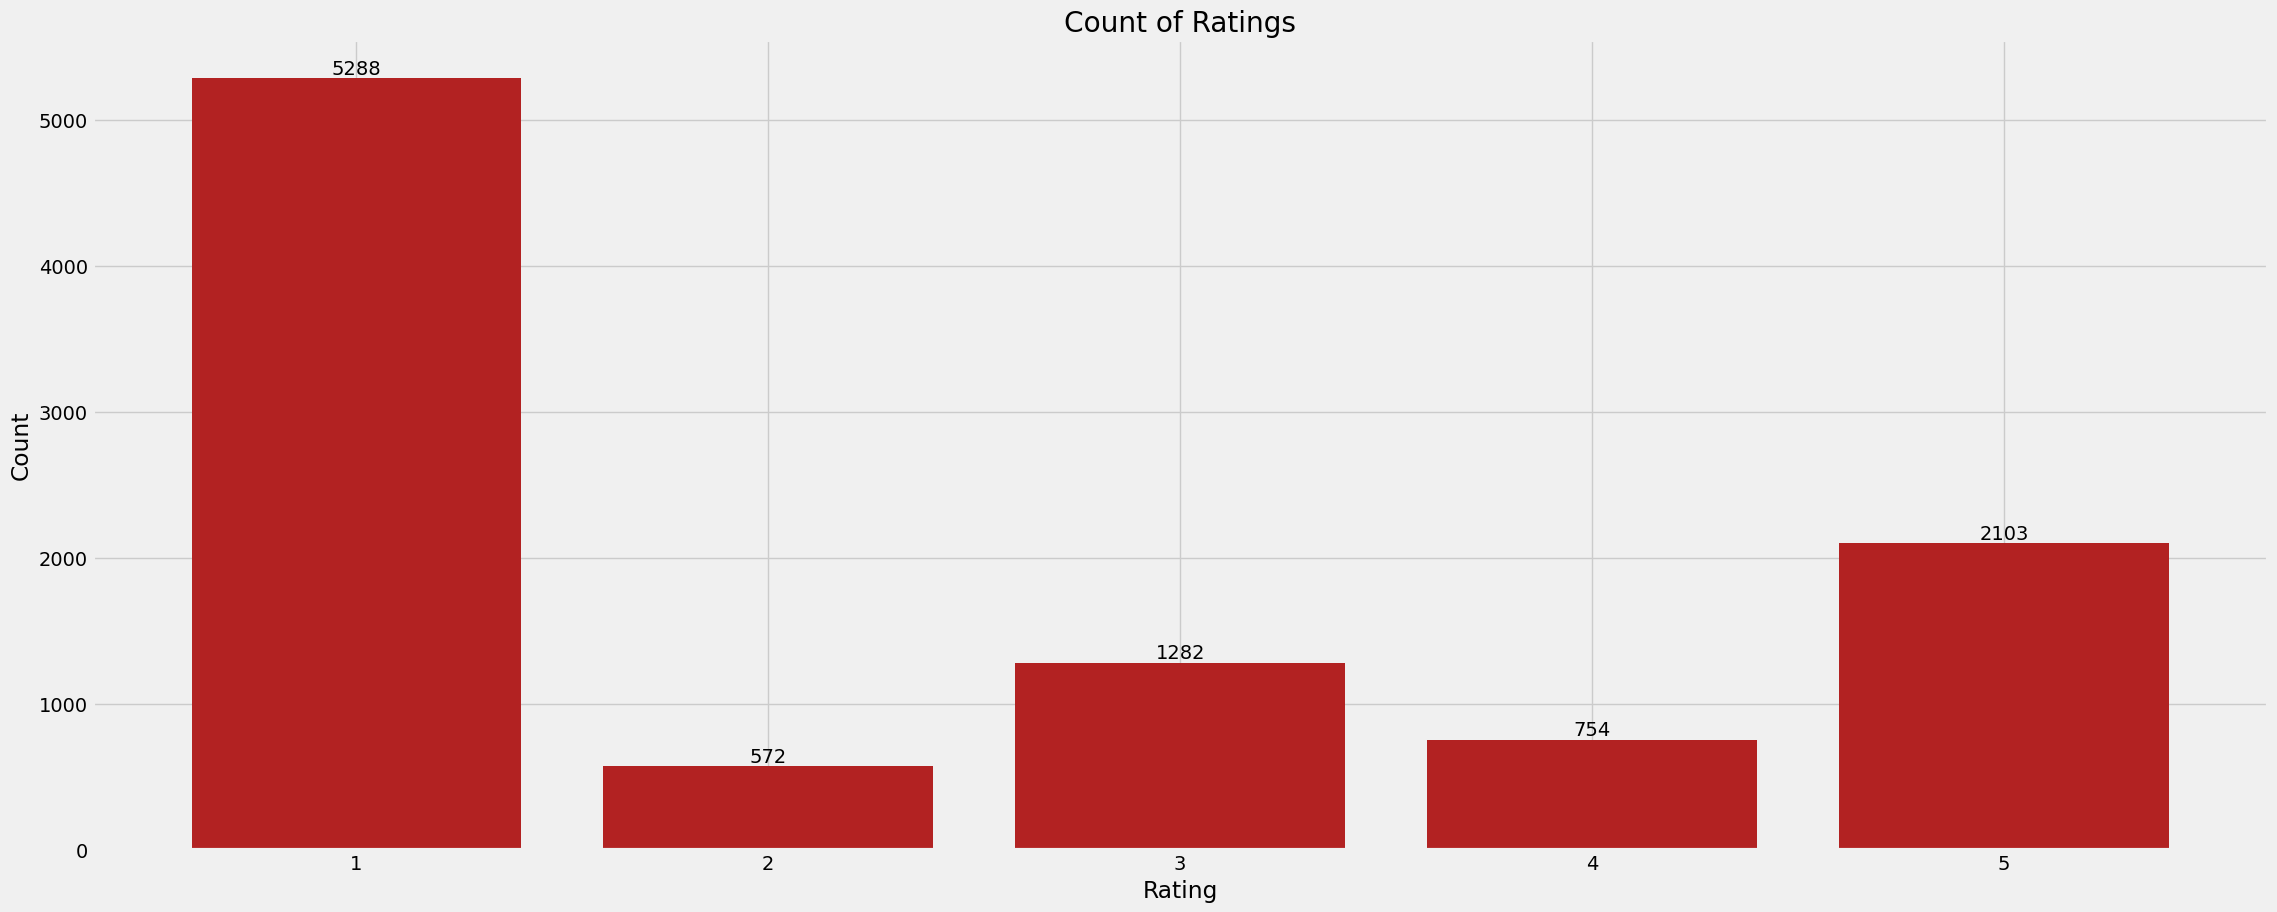

In [16]:
plt.style.use('fivethirtyeight')
fix, ax = plt.subplots(figsize = (25, 10))

ratings = reviews['RATING'].value_counts()
ind = reviews['RATING'].unique()

plt.bar(ind, ratings, color = 'firebrick', align = 'center')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2,
            p.get_height(),
            '{:.0f}'.format(p.get_height()),
            ha='center',
            va='bottom'
           )

plt.title('Count of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [17]:
# dataset is unbalanced, but that is ok in our context as we will not be exploring the relationship between variables, just the underlying text

In [18]:
reviews.head()

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,COUNTRY,LANGUAGE
0,3129911,2022-08-17,True,1,This has NO flavor,"This item has no flavor, several people have tried it in my house and all agree it is flavorless. It of course can NOT be returned so I just waisted $15. Don't waste your money on this garbage.",United States,en
1,2702184,2022-06-07,True,1,Different formula,I have used this brand of sunscreen for about 6 years or so. I've never had any problems until this past month when I purchased a new bottle. The new formula doesn't use nonnano zinc as the previous version did. My child and I have been very badly sunburned twice now. It has to be because of the new formula. I'm very upset because I have allergies and sensitive skin. This was the only brand that has ever worked for me. Thinkbaby should be ashamed for not stating the change in ingredients!,United States,en
2,760128,2014-06-03,True,5,Vitex!!!,"Have been using these for at least 20 months and it was the only product that made a difference in what I would call ""personal summers"" :) Won't use anything else.",United States,en
3,760140,2013-11-24,True,5,Stopping hair loss,"Bought this to help fight hair loss along with dong quai, fo-ti; hair, nail, and skin vitamin by gaia and ginseng. My hair started growing back within a month, stopped breaking within a week's time.",United States,en
4,760132,2014-04-10,True,5,coming off of birth control,"this company is one of the best most honest i've come across. what a wonderfull product , this is a life saver when coming off hormonol birth control",United States,en


## Visualizations p2

Text(0.5, 1.0, 'Number of words by review histogram')

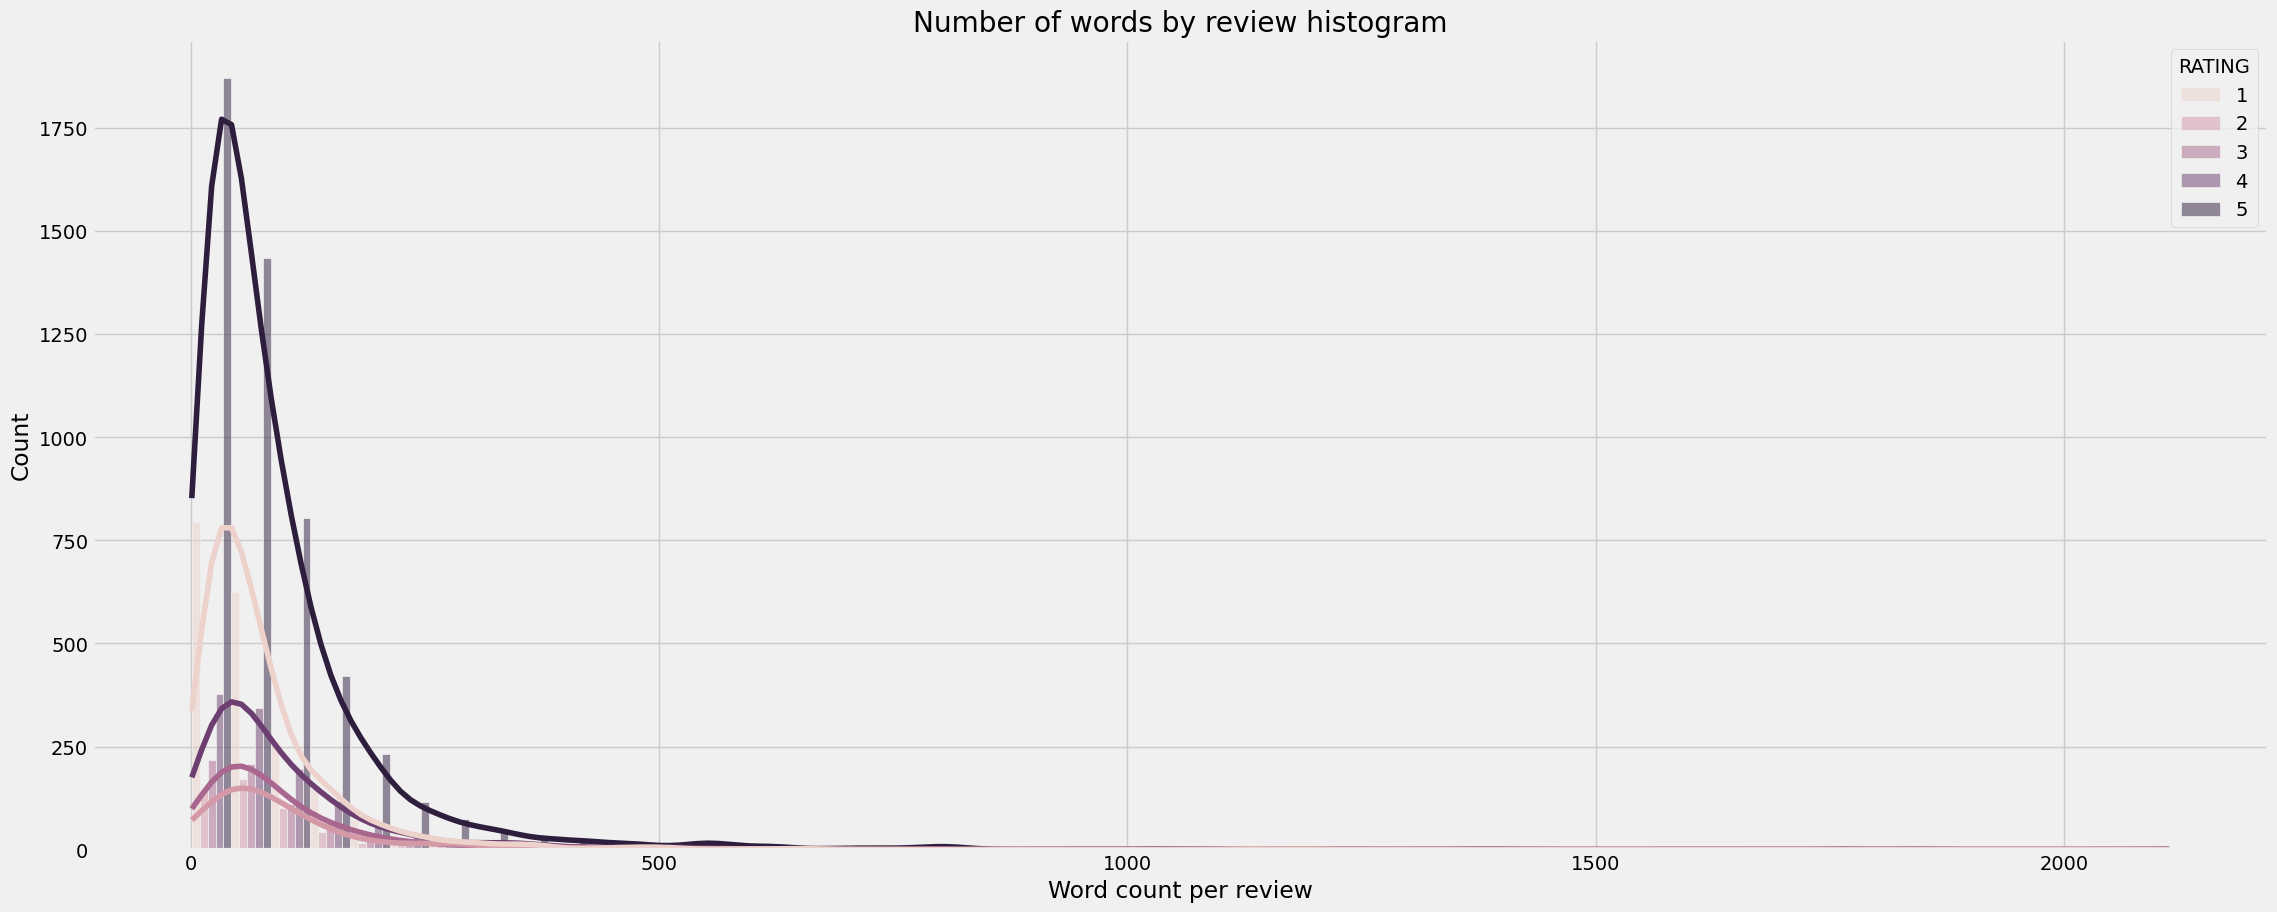

In [19]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

sns.histplot(data=english_reviews, x='word_count', hue='RATING', multiple='dodge', legend='RATING', kde = True, bins = 50)

plt.xlabel('Word count per review')
plt.ylabel('Count')
plt.title('Number of words by review histogram')

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_47574/3030392025.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels = english_reviews['RATING'].unique(), patch_artist=True)


Text(0, 0.5, 'Word count')

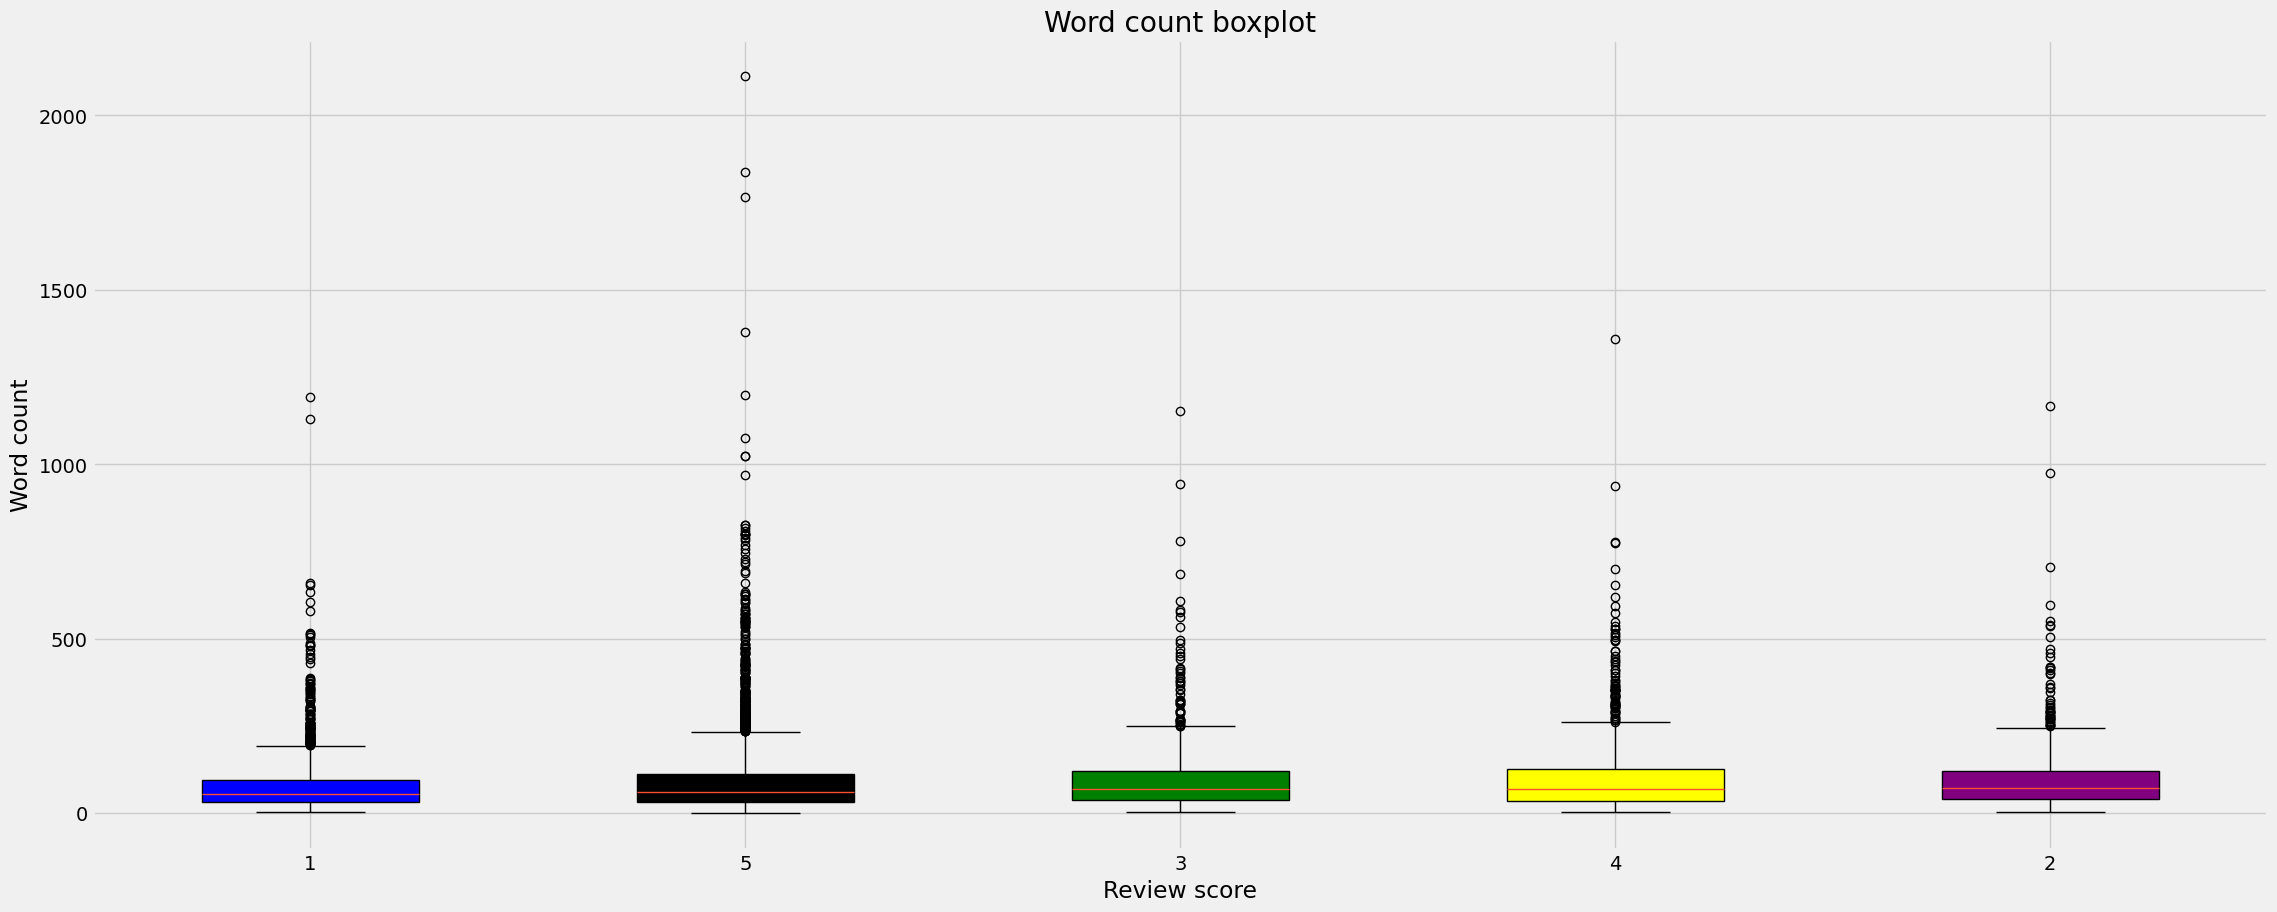

In [20]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

wc_group = english_reviews.groupby('RATING')['word_count'].apply(list)
data = [wc_group[cat] for cat in english_reviews['RATING'].unique()]

bp = plt.boxplot(data, labels = english_reviews['RATING'].unique(), patch_artist=True)

colors = ['blue', 'black', 'green', 'yellow', 'purple']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Word count boxplot')
plt.xlabel('Review score')
plt.ylabel('Word count')

In [21]:
## graph of average score over time

In [22]:
pd.set_option('display.max_colwidth', None)
english_reviews['REVIEW_TEXT'].sample(1, random_state = 14)

7318    I was following the new international travel standards for carryon luggage. Although the airline never checked, probably because the plane was not full, I’m sure it would have met the standards. I was very happy with how well the spinner wheels worked as I could handled two of these bags by holding their handles together. And I am amazed at how well my clothes for 3 weeks fit into the bag. (Of course, I did study “how to pack” articles to plan this)
Name: REVIEW_TEXT, dtype: object

In [23]:
# english_reviews_mini = english_reviews[:4800]

# Count Vectorize

In [24]:
def remove_punctuation(text):
    final_text = []
    for row in text:
        clean_row = "".join(u for u in row if u not in ('?', '.', ';', ':', '!', '"', "'", '(', ')', '[', ']', '/', ',', '-', '*'))
        final_text.append(clean_row.lower())
    
    return final_text

In [25]:
token = RegexpTokenizer(f'[a-zA-Z0-9]+')

In [26]:
english_reviews['REVIEW_TEXT'] = remove_punctuation(english_reviews['REVIEW_TEXT'])

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_47574/2641748750.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['REVIEW_TEXT'] = remove_punctuation(english_reviews['REVIEW_TEXT'])


In [27]:
cv = CountVectorizer(stop_words = 'english', ngram_range = (1,2), tokenizer = token.tokenize)

In [28]:
text_counts = cv.fit_transform(english_reviews['REVIEW_TEXT'])

/Users/cman/Desktop/code/customer_reviews/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# Train Test Split P2

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, english_reviews['RATING'], test_size = 0.2, random_state = 42, stratify=english_reviews['RATING'])

# Training the MNB model 

In [30]:
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

MultinomialNB()

In [31]:
predicted = MNB.predict(X_test)

In [32]:
acc_score = accuracy_score(predicted, Y_test)

In [33]:
print(f'The accuracy score of the Multimodial Naive Bayes model is: {round(acc_score, 2)}')

The accuracy score of the Multimodial Naive Bayes model is: 0.61


In [34]:
predicted[:5]

array([5, 5, 5, 5, 5])

In [35]:
Y_test[:5]

3877    5
7159    1
4104    5
4698    5
259     5
Name: RATING, dtype: int64

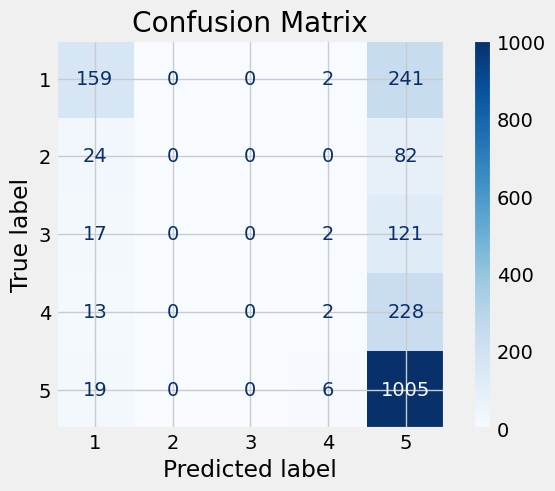

In [36]:
cm = confusion_matrix(Y_test, predicted)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.unique(Y_test))
disp.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Text blob

Polartiy determines the sentiment of the text. -1 = highly negative review and 1 denotes a highly positive sentiment.

Subjectivity determines whether a text input is fact vs personal information. 0 denotes a fact and 1 denotes a personal opinion.

In [37]:
english_reviews['REVIEW_TEXT'].iloc[284]

'certainly theres better cameras out there that i dont know about but this camera is my pride and joy i would get a lens for zooming further out but its still an amazing camera i know nothing about specs or what makes this camera so good i just know that for a beginner like me its amazing'

In [38]:
p1 = TextBlob(english_reviews['REVIEW_TEXT'].iloc[284]).sentiment.polarity
s1 = TextBlob(english_reviews['REVIEW_TEXT'].iloc[284]).sentiment.subjectivity

In [39]:
print(f'The polarity of the test token is : {round(p1, 4)} and the subjectivity of the test token is: {round(s1, 4)}')

The polarity of the test token is : 0.4878 and the subjectivity of the test token is: 0.5959


In [40]:
print(f'The actual rating was: {english_reviews['RATING'].iloc[284]}')

The actual rating was: 5


In [41]:
def calculate_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

def calculate_subjectivity(text):
    blob = TextBlob(text)
    return blob.sentiment.subjectivity

In [42]:
english_reviews['TEXT_BLOB_POLARITY_RAW'] = english_reviews['REVIEW_TEXT'].apply(calculate_polarity)
english_reviews['TEXT_BLOB_SUBJECTIVITY_RAW'] = english_reviews['REVIEW_TEXT'].apply(calculate_subjectivity)

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_47574/1677028977.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['TEXT_BLOB_POLARITY_RAW'] = english_reviews['REVIEW_TEXT'].apply(calculate_polarity)
/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_47574/1677028977.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['TEXT_BLOB_SUBJECTIVITY_RAW'] = english_reviews['REVIEW_TEXT'].apply(calculate_subjectivity)


In [43]:
def map_rating(value):
    mapped_value = (value + 1) * 2.5 + 0.5
    mapped_rating = round(mapped_value)
    mapped_rating = max(1, min(5, mapped_rating))
    return mapped_rating

In [44]:
english_reviews['TEXT_BLOB_POLARITY_MAPPED'] = english_reviews['TEXT_BLOB_POLARITY_RAW'].apply(map_rating)

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_47574/441747895.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['TEXT_BLOB_POLARITY_MAPPED'] = english_reviews['TEXT_BLOB_POLARITY_RAW'].apply(map_rating)


In [58]:
english_reviews.sample(1)

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,COUNTRY,LANGUAGE,word_count,TEXT_BLOB_POLARITY_RAW,TEXT_BLOB_SUBJECTIVITY_RAW,TEXT_BLOB_POLARITY_MAPPED
1729,9200373,2023-10-01,True,1,I feel ripped off,i thought i was getting 5 cans i only got one can$1649 for one can pringles all crumbs and no can return,United States,en,22,0.0,1.0,3


In [46]:
english_reviews['TEXT_BLOB_POLARITY_MAPPED'].values

array([3, 3, 3, ..., 4, 3, 5])

In [47]:
english_reviews['RATING'].values

array([1, 1, 5, ..., 5, 5, 5])

In [48]:
acc_score_2 = accuracy_score(english_reviews['TEXT_BLOB_POLARITY_MAPPED'].values, english_reviews['RATING'].values)

In [49]:
print(f'The accuracy score of the \'Text Blob\' model accuracy score is: {round(acc_score_2, 4)}')

The accuracy score of the 'Text Blob' model accuracy score is: 0.1326


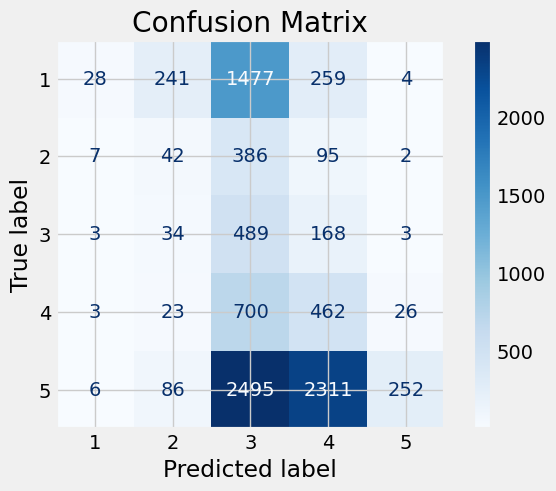

In [59]:
cm = confusion_matrix(english_reviews['RATING'].values, english_reviews['TEXT_BLOB_POLARITY_MAPPED'].values)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.unique(Y_test))
disp.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# VADER

In [50]:
sentiment = SentimentIntensityAnalyzer()

In [51]:
t_1 = english_reviews['REVIEW_TEXT'].iloc[1336]
t_1

'when i read one of the reviews for this supplement  someone said it worked just after one weekand after many high reviews i decided to give it a try unbelievable but my husbands blood pressure lowered within a week of regular taking  from high blood pressure he is back to 12078  i will recommend it to everyone i know  and definitely share the news with other family members give it a try it works'

In [52]:
sent_1 = sentiment.polarity_scores(t_1)
print(f'The VADER sentiment of review 1337 is: {sent_1}')

The sentiment of review 1337 is : {'neg': 0.086, 'neu': 0.785, 'pos': 0.129, 'compound': 0.5647}


In [64]:
print(f'The actual rating for review 1337 is: {english_reviews['RATING'].iloc[1336]}')

The actual rating for review 1337 is: 5


In [66]:
def calculate_sentiment(text):
    vader = sentiment.polarity_scores(text)
    return vader

In [67]:
english_reviews['VADER_SENTIMENT_RAW'] = english_reviews['REVIEW_TEXT'].apply(calculate_sentiment)

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_47574/1169201452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['VADER_SENTIMENT_RAW'] = english_reviews['REVIEW_TEXT'].apply(calculate_sentiment)


In [72]:
english_reviews.iloc[72]

ID                                                                                                   7822915
REVIEW_DATE                                                                              2016-01-14 00:00:00
IS_VERIFIED                                                                                             True
RATING                                                                                                     5
REVIEW_TITLE                                                                                      Five Stars
REVIEW_TEXT                   i use this with acrylic paint and it works and blends well it is worth the buy
COUNTRY                                                                                               Canada
LANGUAGE                                                                                                  en
word_count                                                                                                17
TEXT_BLOB_POLARITY_

In [62]:
def map_sentiment(sentiment):
    pos_score = sentiment['pos']
    neg_score = sentiment['neg']

    weighted_score = (pos_score - neg_score) * 2 + 3
    mapped_score = round(max(1, min(5, weighted_score)))
    return mapped_score

In [65]:
print(f'The mapped sentiment for review 1337 is: {map_sentiment(sent_1)}')

The mapped sentiment for review 1337 is: 3


In [70]:
english_reviews['VADER_SENTIMENT_MAPPED'] = english_reviews['VADER_SENTIMENT_RAW'].apply(map_sentiment)

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_47574/584837358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['VADER_SENTIMENT_MAPPED'] = english_reviews['VADER_SENTIMENT_RAW'].apply(map_sentiment)


In [73]:
english_reviews.iloc[72]

ID                                                                                                   7822915
REVIEW_DATE                                                                              2016-01-14 00:00:00
IS_VERIFIED                                                                                             True
RATING                                                                                                     5
REVIEW_TITLE                                                                                      Five Stars
REVIEW_TEXT                   i use this with acrylic paint and it works and blends well it is worth the buy
COUNTRY                                                                                               Canada
LANGUAGE                                                                                                  en
word_count                                                                                                17
TEXT_BLOB_POLARITY_

In [75]:
acc_score_3 = accuracy_score(english_reviews['VADER_SENTIMENT_MAPPED'].values, english_reviews['RATING'].values)

In [76]:
print(f'The accuracy score of the \'VADER\' model accuracy score is: {round(acc_score_3, 4)}')

The accuracy score of the 'VADER' model accuracy score is: 0.0844


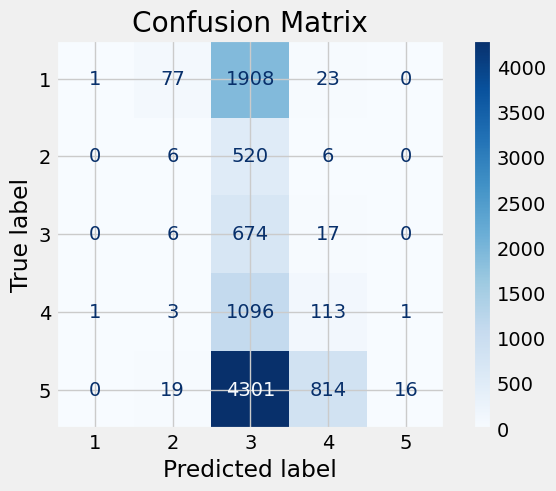

In [74]:
cm = confusion_matrix(english_reviews['RATING'].values, english_reviews['VADER_SENTIMENT_MAPPED'].values)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.unique(Y_test))
disp.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()